## GSE190389 – Diurnal mRNA expression profiles from 22 tissues – response to time restricted feeding in mammals

- So here is another study on time restricted feending but now in mice and generaly more encompassing
- 22 organs and brain regions
- 2h over a 24h period
- TRF influences gene expression and significantly increases the amount of rhythmic transcripts
- https://pubmed.ncbi.nlm.nih.gov/36599299/

In [3]:
import COFE.analyse
import COFE.scpca
import COFE.plot
import numpy as np
import anndata as ad
import pandas as pd
import PCA_func as pc
import matplotlib.pyplot as plt
from umap import UMAP

### Step 1: Open Dataset

In [23]:
path = '/Users/maksimsgolubovics/Python_VScode/Studienprojekt/rnaseq_datasets/GSE190389_rnaseq.h5ad'
adata = ad.read_h5ad(path)

#Transform to DataFrame
data_df = pd.DataFrame(data=adata.X, columns=adata.var.index, index=adata.obs.index).T

#Look at sampeles features
adata.var[['tissue', 'time', 'diet', 'rep']]
adata.var['rep'].unique()

/Users/maksimsgolubovics/Python_VScode/.venv/lib/python3.13/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


['1', '2']
Categories (2, object): ['1', '2']

### Step 2: Prepare The Dataset

In [14]:
data_df_log = np.log10(data_df + 0.1) #Logarithmic transformation

### Step 3: Exploratory Analysis

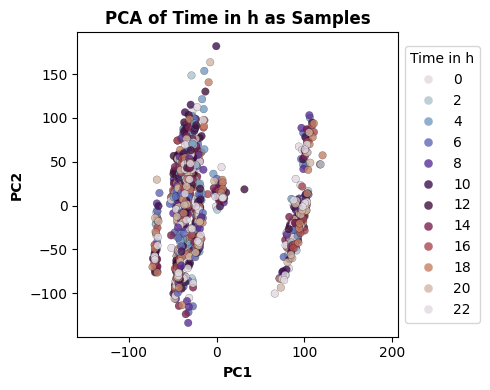

In [15]:
data_df_log_time = data_df_log.join(adata.var['time']).reset_index().set_index('time').drop('index', axis=1)
pc.principal_component_2d_timesample(data=data_df_log_time, label='Time in h', c_map='twilight')

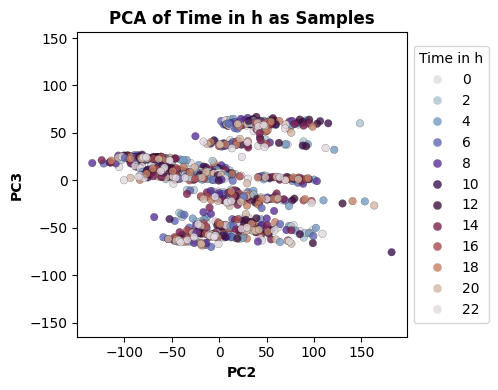

In [16]:
pc.principal_component_2d_timesample(data=data_df_log_time, x=2, y=3, label='Time in h', c_map='twilight')

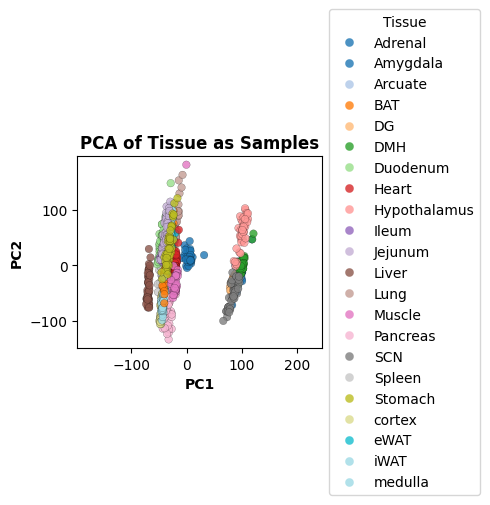

In [18]:
data_df_log_subject = data_df_log.join(adata.var['tissue']).reset_index().set_index('tissue').drop('index', axis=1)
pc.principal_component_2d_timesample(data=data_df_log_subject, label='Tissue', c_map='tab20')

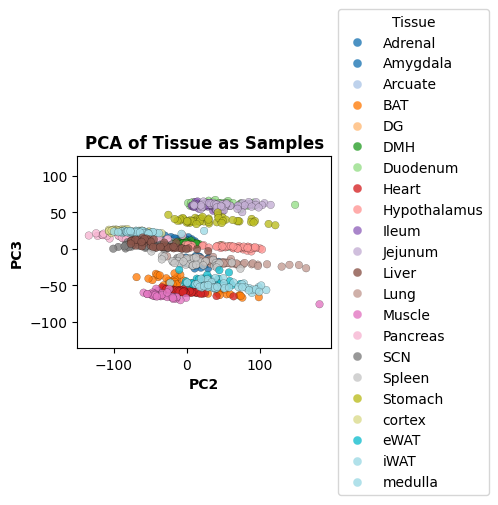

In [19]:
data_df_log_subject = data_df_log.join(adata.var['tissue']).reset_index().set_index('tissue').drop('index', axis=1)
pc.principal_component_2d_timesample(data=data_df_log_subject, x=2, y=3, label='Tissue', c_map='tab20')

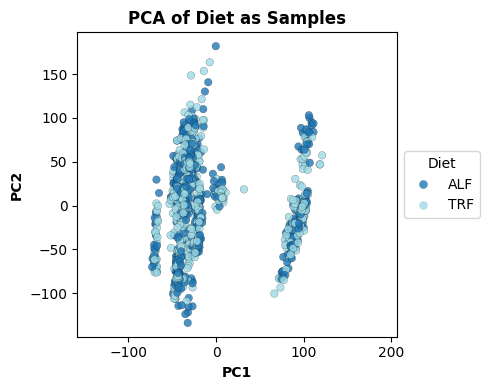

In [21]:
data_df_log_subject = data_df_log.join(adata.var['diet']).reset_index().set_index('diet').drop('index', axis=1)
pc.principal_component_2d_timesample(data=data_df_log_subject, label='Diet', c_map='tab20')

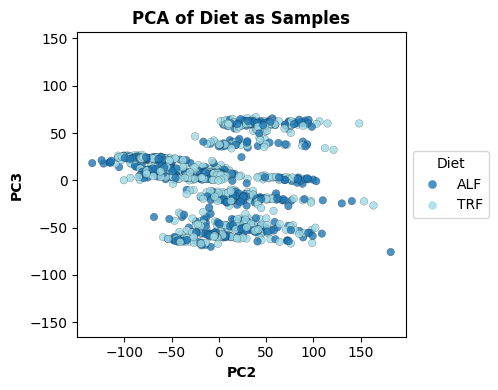

In [22]:
data_df_log_subject = data_df_log.join(adata.var['diet']).reset_index().set_index('diet').drop('index', axis=1)
pc.principal_component_2d_timesample(data=data_df_log_subject, x=2, y=3, label='Diet', c_map='tab20')

##### In this dataset, I will analyze each organ individually to see how COFE performs in each organ compared to the others.

## COFE: Adrenal

### Identify Mean and Std Threshold valuse

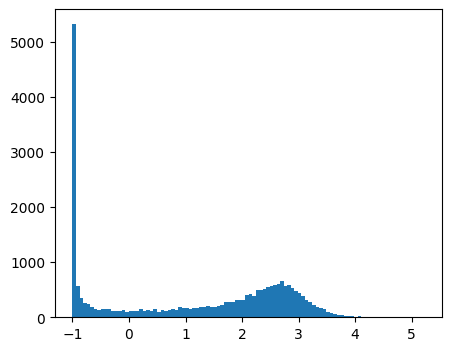

In [25]:
plt.figure(figsize=(5, 4))
plt.hist(x=data_df_log[adata.var['tissue'] == 'Adrenal'].mean(), bins=100);

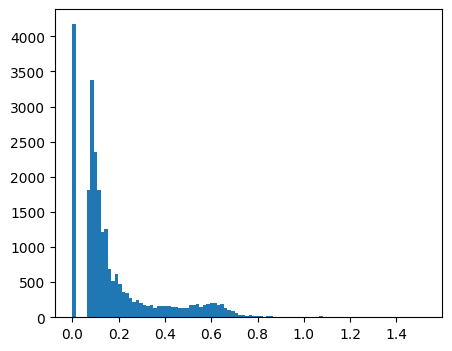

In [26]:
plt.figure(figsize=(5, 4))
plt.hist(x=data_df_log[adata.var['tissue'] == 'Adrenal'].std(), bins=100);

### COFE: Adrenal All Samples

In [55]:
X_train_a = data_df_log[adata.var['tissue'] == 'Adrenal']
true_time_train_a = adata.var[adata.var['tissue'] == 'Adrenal']['time'].astype(int)

X_train_a, X_test_a, features_a, features_std_a = COFE.analyse.preprocess_data(X_train_a.to_numpy(), None, 
                                                                           features=X_train_a.columns, feature_dim='col',
                                                                           mean_threshold=1, scaling_threshold=12)
X_train_a.shape # (Samples, Transcripts)

(48, 10493)

In [46]:
s_choices = np.linspace(1, 50, 15)
cv_a = COFE.analyse.cross_validate(X_train_a, s_choices, features=features_a, K=5, ncores=-1)

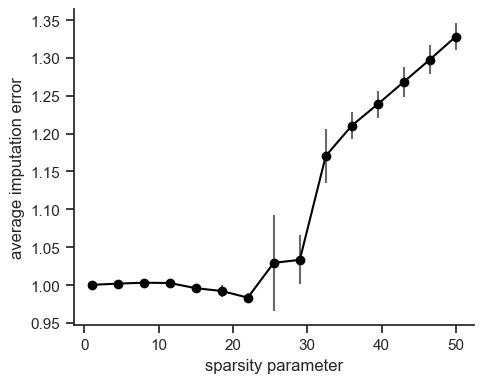

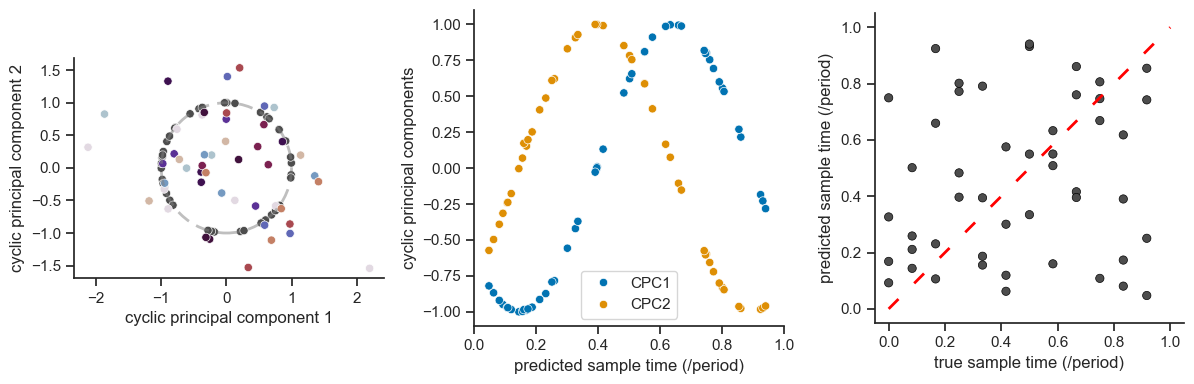

In [56]:
results_train_diet_a = COFE.analyse.predict_time(X_train_a, cv_a, true_times=true_time_train_a.to_numpy(), period=24)
COFE.plot.plot_cv_run(results_train_diet_a, figsize=(5,4))
COFE.plot.plot_circular_ordering(results_train_diet_a, time=true_time_train_a.to_numpy(), X=X_train_a, figsize=(12, 4), period=24)

In [57]:
results_train_diet_a["MAPE"]*24

np.float64(4.239107259350234)

### COFE: Adrenal TRF

In [68]:
X_train_b = data_df_log[(adata.var['tissue'] == 'Adrenal') & (adata.var['diet'] == 'TRF')]
true_time_train_b = adata.var[(adata.var['tissue'] == 'Adrenal') & (adata.var['diet'] == 'TRF')]['time'].astype(int)

X_train_b, X_test_b, features_b, features_std_b = COFE.analyse.preprocess_data(X_train_b.to_numpy(), None, 
                                                                           features=X_train_b.columns, feature_dim='col',
                                                                           mean_threshold=1, scaling_threshold=13)
X_train_b.shape # (Samples, Transcripts)

(24, 9689)

In [69]:
s_choices = np.linspace(1, 50, 15)
cv_b = COFE.analyse.cross_validate(X_train_b, s_choices, features=features_b, K=5, ncores=-1)

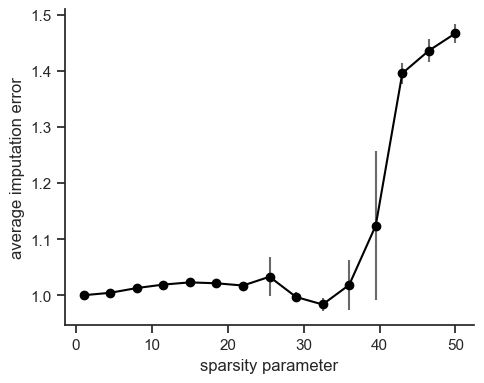

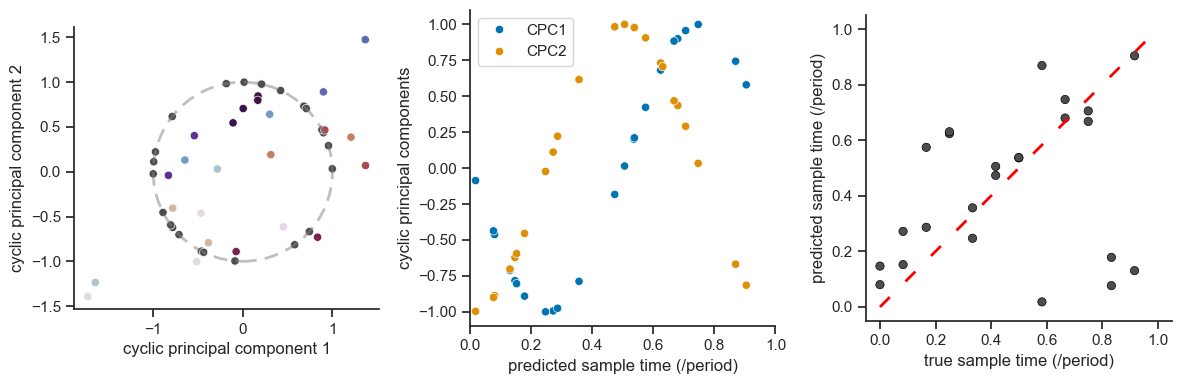

In [70]:
results_train_diet_b = COFE.analyse.predict_time(X_train_b, cv_b, true_times=true_time_train_b.to_numpy(), period=24)
COFE.plot.plot_cv_run(results_train_diet_b, figsize=(5,4))
COFE.plot.plot_circular_ordering(results_train_diet_b, time=true_time_train_b.to_numpy(), X=X_train_b, figsize=(12, 4), period=24)

In [71]:
results_train_diet_b["MAPE"]*24

np.float64(2.105914517745541)

### COFE: Adrenal ALF

In [245]:
X_train_c = data_df_log[(adata.var['tissue'] == 'Adrenal') & (adata.var['diet'] == 'ALF')]
true_time_train_c = adata.var[(adata.var['tissue'] == 'Adrenal') & (adata.var['diet'] == 'ALF')]['time'].astype(int)

X_train_c, X_test_c, features_c, features_std_c = COFE.analyse.preprocess_data(X_train_c.to_numpy(), None, 
                                                                           features=X_train_c.columns, feature_dim='col',
                                                                           mean_threshold=1, scaling_threshold=11.2)
X_train_c.shape # (Samples, Transcripts)

(24, 9699)

In [246]:
s_choices = np.linspace(1, 50, 15)
cv_c = COFE.analyse.cross_validate(X_train_c, s_choices, features=features_c, K=5, ncores=-1)

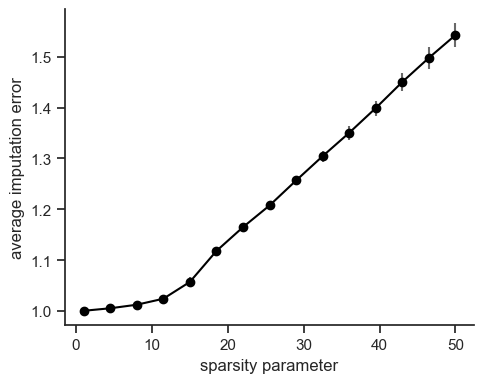

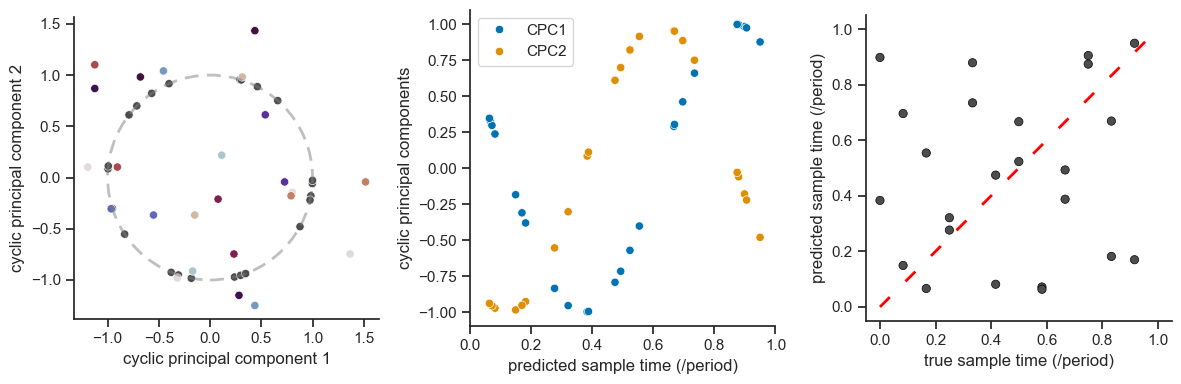

In [248]:
results_train_diet_c = COFE.analyse.predict_time(X_train_c, cv_c, true_times=true_time_train_c.to_numpy(), period=24)
COFE.plot.plot_cv_run(results_train_diet_c, figsize=(5,4))
COFE.plot.plot_circular_ordering(results_train_diet_c, time=true_time_train_c.to_numpy(), X=X_train_c, figsize=(12, 4), period=24)

In [249]:
results_train_diet_c["MAPE"]*24

np.float64(4.086306354361)

## COFE: Amygdala

### COFE: Amygdala All Samples

In [93]:
X_train_d = data_df_log[(adata.var['tissue'] == 'Amygdala')]
true_time_train_d = adata.var[(adata.var['tissue'] == 'Amygdala')]['time'].astype(int)

X_train_d, X_test_d, features_d, features_std_d = COFE.analyse.preprocess_data(X_train_d.to_numpy(), None, 
                                                                           features=X_train_d.columns, feature_dim='col',
                                                                           mean_threshold=1, scaling_threshold=6.4)
X_train_d.shape # (Samples, Transcripts)

(46, 9635)

In [94]:
s_choices = np.linspace(1, 50, 15)
cv_d = COFE.analyse.cross_validate(X_train_d, s_choices, features=features_d, K=5, ncores=-1)

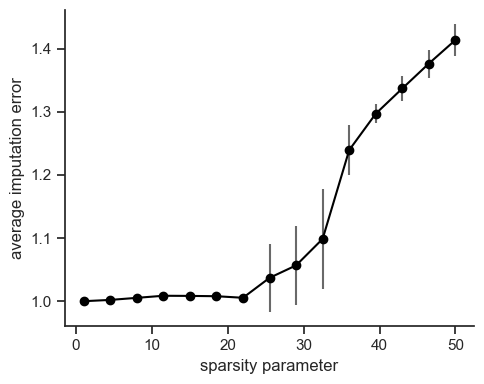

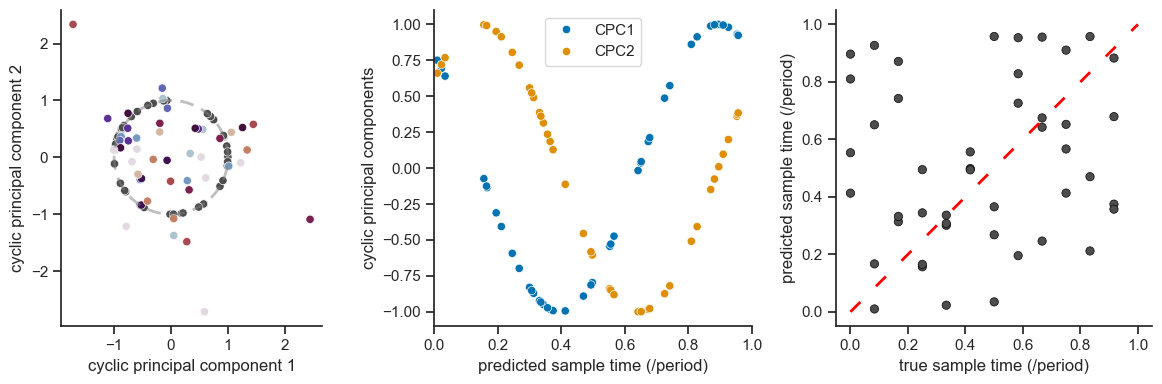

In [102]:
results_train_diet_d = COFE.analyse.predict_time(X_train_d, cv_d, true_times=true_time_train_d.to_numpy(), period=24)
COFE.plot.plot_cv_run(results_train_diet_d, figsize=(5,4))
COFE.plot.plot_circular_ordering(results_train_diet_d, time=true_time_train_d.to_numpy(), X=X_train_d, figsize=(12, 4), period=24)

### COFE: Amygdala TRF

In [744]:
X_train_e = data_df_log[(adata.var['tissue'] == 'Amygdala') & (adata.var['diet'] == 'TRF')]
true_time_train_e = adata.var[(adata.var['tissue'] == 'Amygdala') & (adata.var['diet'] == 'TRF')]['time'].astype(int)

X_train_e, X_test_e, features_e, features_std_e = COFE.analyse.preprocess_data(X_train_e.to_numpy(), None, 
                                                                           features=X_train_e.columns, feature_dim='col',
                                                                           mean_threshold=1, scaling_threshold=5)
X_train_e.shape # (Samples, Transcripts)

(23, 2899)

In [745]:
s_choices = np.linspace(1, 50, 15)
cv_e = COFE.analyse.cross_validate(X_train_e, s_choices, features=features_e, K=5, ncores=-1)

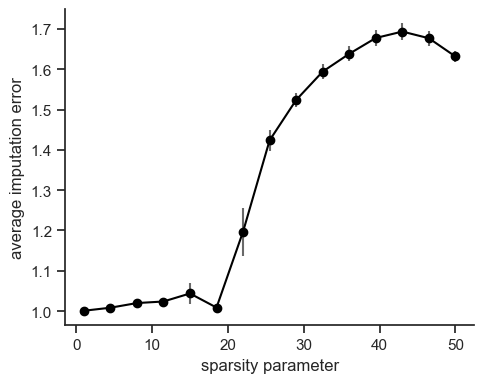

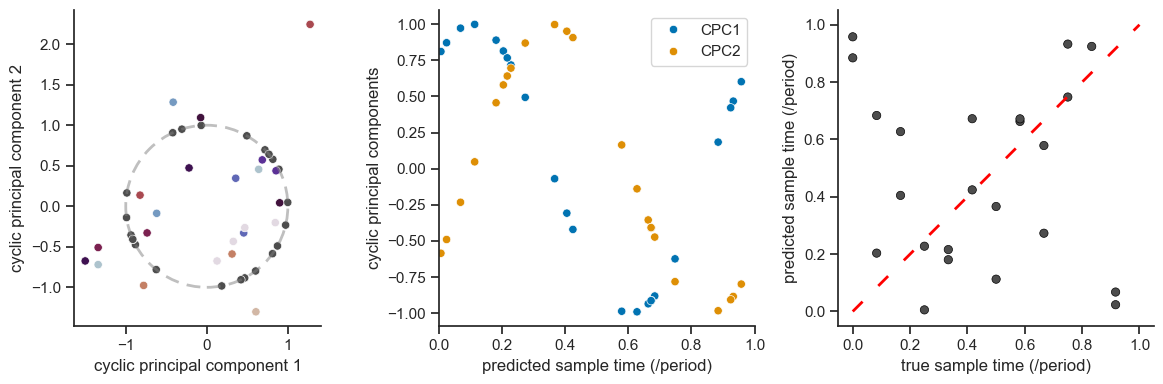

In [746]:
results_train_diet_e = COFE.analyse.predict_time(X_train_e, cv_e, true_times=true_time_train_e.to_numpy(), period=24)
COFE.plot.plot_cv_run(results_train_diet_e, figsize=(5,4))
COFE.plot.plot_circular_ordering(results_train_diet_e, time=true_time_train_e.to_numpy(), X=X_train_e, figsize=(12, 4), period=24)

In [747]:
results_train_diet_e["MAPE"]*24

np.float64(2.882908285126902)

### COFE: Amygdala ALF

In [748]:
X_train_f = data_df_log[(adata.var['tissue'] == 'Amygdala') & (adata.var['diet'] == 'ALF')]
true_time_train_f = adata.var[(adata.var['tissue'] == 'Amygdala') & (adata.var['diet'] == 'ALF')]['time'].astype(int)

X_train_f, X_test_f, features_f, features_std_f = COFE.analyse.preprocess_data(X_train_f.to_numpy(), None, 
                                                                           features=X_train_f.columns, feature_dim='col',
                                                                           mean_threshold=1, scaling_threshold=5.3)
X_train_f.shape # (Samples, Transcripts)

(23, 3903)

In [749]:
s_choices = np.linspace(1, 50, 15)
cv_f = COFE.analyse.cross_validate(X_train_f, s_choices, features=features_f, K=5, ncores=-1)

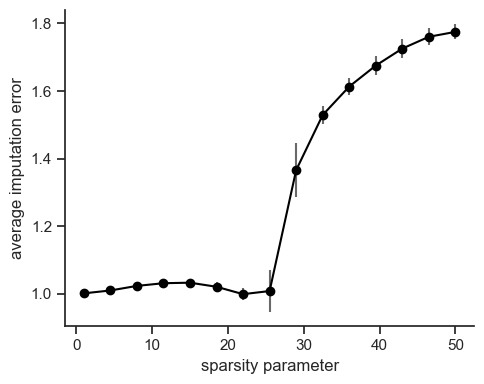

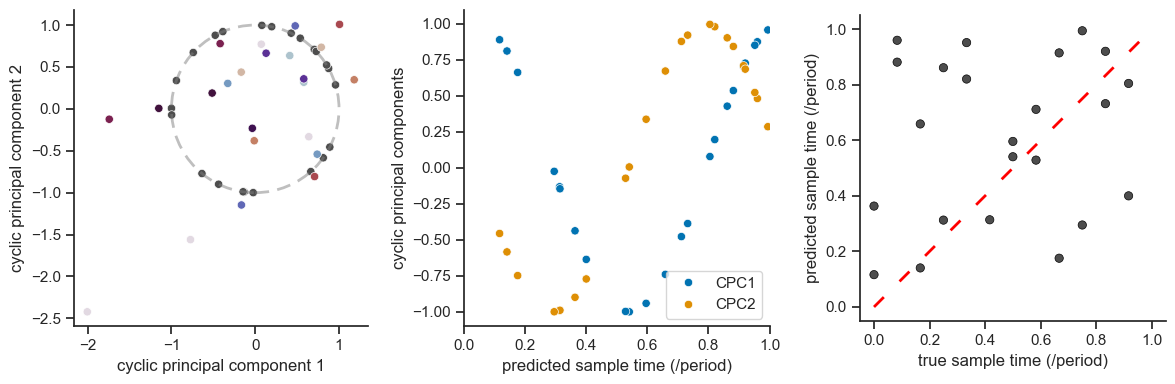

In [750]:
results_train_diet_f = COFE.analyse.predict_time(X_train_f, cv_f, true_times=true_time_train_f.to_numpy(), period=24)
COFE.plot.plot_cv_run(results_train_diet_f, figsize=(5,4))
COFE.plot.plot_circular_ordering(results_train_diet_f, time=true_time_train_f.to_numpy(), X=X_train_f, figsize=(12, 4), period=24)

In [751]:
results_train_diet_f["MAPE"]*24

np.float64(3.074276386468128)

## COFE: Arcuate

### COFE: Arcuate All Samples

In [386]:
X_train_g = data_df_log[(adata.var['tissue'] == 'Arcuate')]
true_time_train_g = adata.var[(adata.var['tissue'] == 'Arcuate')]['time'].astype(int)

X_train_g, X_test_g, features_g, features_std_g = COFE.analyse.preprocess_data(X_train_g.to_numpy(), None, 
                                                                           features=X_train_g.columns, feature_dim='col',
                                                                           mean_threshold=1, scaling_threshold=10)
X_train_g.shape # (Samples, Transcripts)

(46, 7499)

In [387]:
s_choices = np.linspace(1, 50, 15)
cv_g = COFE.analyse.cross_validate(X_train_g, s_choices, features=features_g, K=5, ncores=-1)

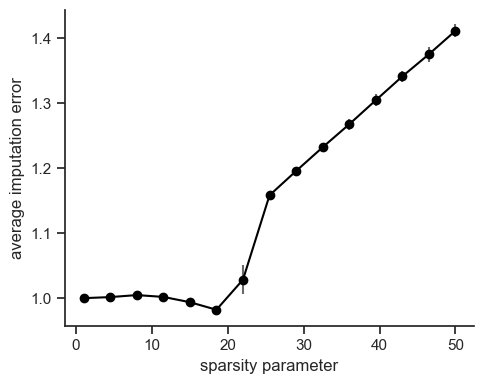

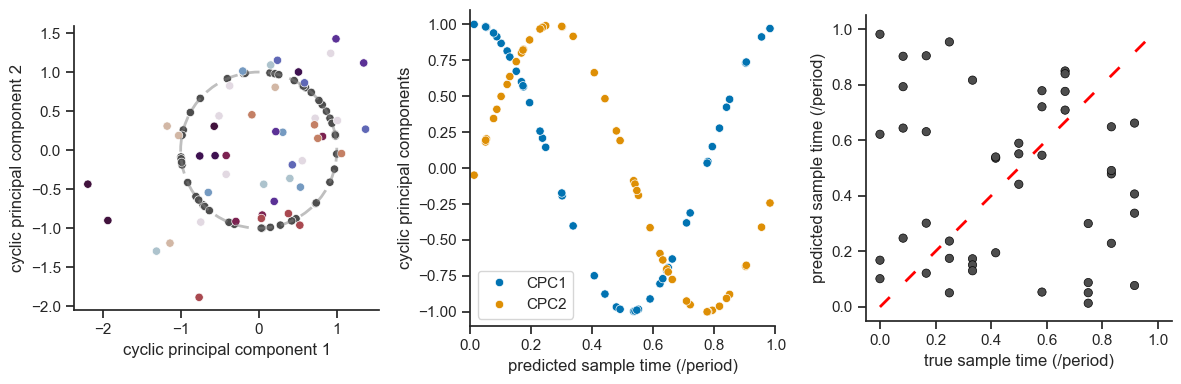

In [389]:
results_train_diet_g = COFE.analyse.predict_time(X_train_g, cv_g, true_times=true_time_train_g.to_numpy(), period=24)
COFE.plot.plot_cv_run(results_train_diet_g, figsize=(5,4))
COFE.plot.plot_circular_ordering(results_train_diet_g, time=true_time_train_g.to_numpy(), X=X_train_g, figsize=(12, 4), period=24)

In [390]:
results_train_diet_g["MAPE"]*24

np.float64(4.412332245183313)

### COFE: Arcuate TRF

In [382]:
X_train_k = data_df_log[(adata.var['tissue'] == 'Arcuate') & (adata.var['diet'] == 'TRF')]
true_time_train_k = adata.var[(adata.var['tissue'] == 'Arcuate') & (adata.var['diet'] == 'TRF')]['time'].astype(int)

X_train_k, X_test_k, features_k, features_std_k = COFE.analyse.preprocess_data(X_train_k.to_numpy(), None, 
                                                                           features=X_train_k.columns, feature_dim='col',
                                                                           mean_threshold=1, scaling_threshold=10)
X_train_k.shape # (Samples, Transcripts)

(23, 7160)

In [383]:
s_choices = np.linspace(1, 50, 15)
cv_k = COFE.analyse.cross_validate(X_train_k, s_choices, features=features_k, K=5, ncores=-1)

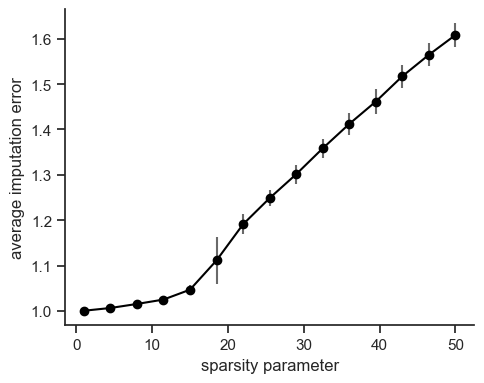

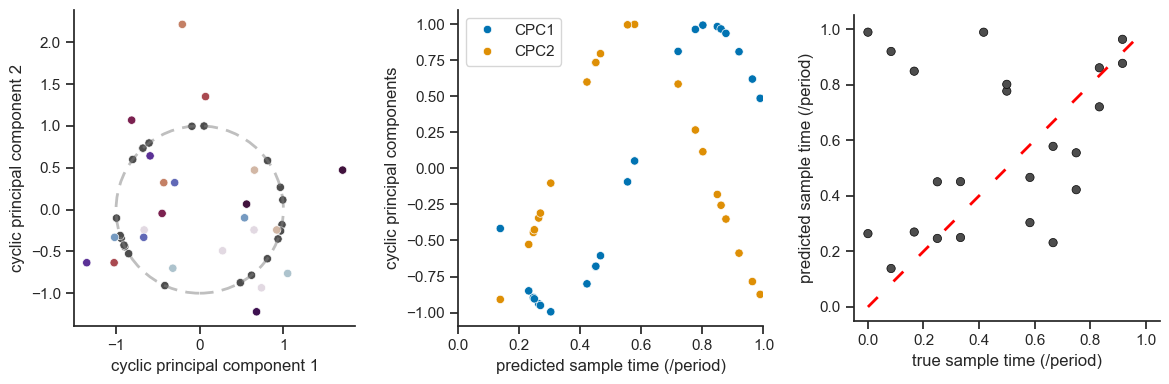

In [384]:
results_train_diet_k = COFE.analyse.predict_time(X_train_k, cv_k, true_times=true_time_train_k.to_numpy(), period=24)
COFE.plot.plot_cv_run(results_train_diet_k, figsize=(5,4))
COFE.plot.plot_circular_ordering(results_train_diet_k, time=true_time_train_k.to_numpy(), X=X_train_k, figsize=(12, 4), period=24)

In [385]:
results_train_diet_k["MAPE"]*24

np.float64(2.8299645974629435)

### COFE: Arcuate ALF

In [764]:
X_train_l = data_df_log[(adata.var['tissue'] == 'Arcuate') & (adata.var['diet'] == 'ALF')]
true_time_train_l = adata.var[(adata.var['tissue'] == 'Arcuate') & (adata.var['diet'] == 'ALF')]['time'].astype(int)

X_train_l, X_test_l, features_l, features_std_l = COFE.analyse.preprocess_data(X_train_l.to_numpy(), None, 
                                                                           features=X_train_l.columns, feature_dim='col',
                                                                           mean_threshold=1, scaling_threshold=11)
X_train_l.shape # (Samples, Transcripts)

(23, 8699)

In [765]:
s_choices = np.linspace(1, 50, 15)
cv_l = COFE.analyse.cross_validate(X_train_l, s_choices, features=features_l, K=5, ncores=-1)

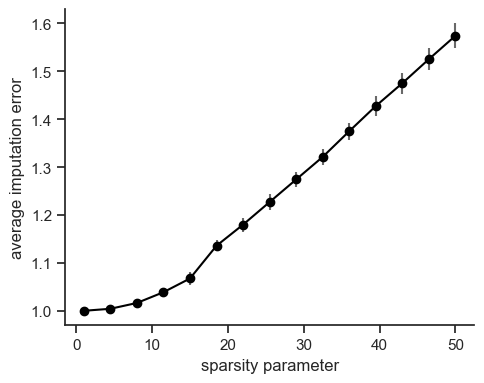

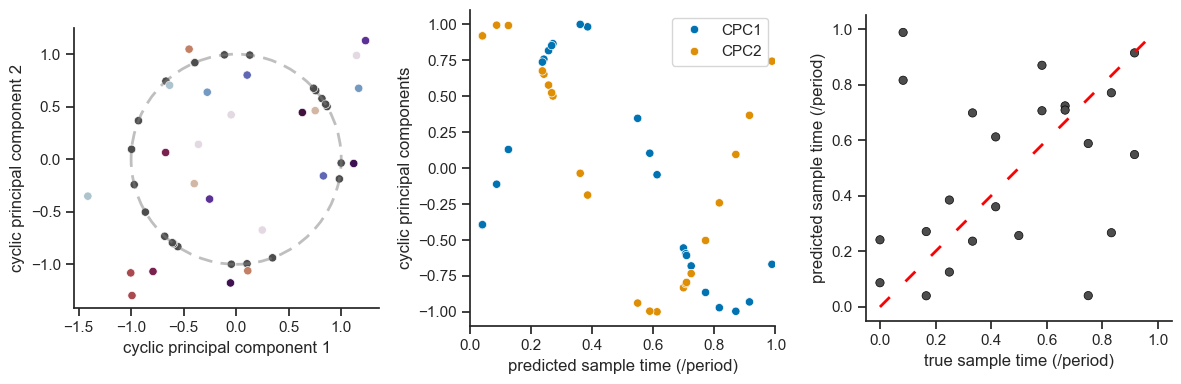

In [766]:
results_train_diet_l = COFE.analyse.predict_time(X_train_l, cv_l, true_times=true_time_train_l.to_numpy(), period=24)
COFE.plot.plot_cv_run(results_train_diet_l, figsize=(5,4))
COFE.plot.plot_circular_ordering(results_train_diet_l, time=true_time_train_l.to_numpy(), X=X_train_l, figsize=(12, 4), period=24)

In [767]:
results_train_diet_l["MAPE"]*24

np.float64(3.034808315998582)

## COFE: BAT

### COFE: BAT All Samples

In [428]:
X_train_m = data_df_log[(adata.var['tissue'] == 'BAT')]
true_time_train_m = adata.var[(adata.var['tissue'] == 'BAT')]['time'].astype(int)

X_train_m, X_test_m, features_m, features_std_m = COFE.analyse.preprocess_data(X_train_m.to_numpy(), None, 
                                                                           features=X_train_m.columns, feature_dim='col',
                                                                           mean_threshold=1, scaling_threshold=2.8)
X_train_m.shape # (Samples, Transcripts)

(48, 5955)

In [429]:
s_choices = np.linspace(1, 50, 15)
cv_m = COFE.analyse.cross_validate(X_train_m, s_choices, features=features_m, K=5, ncores=-1)

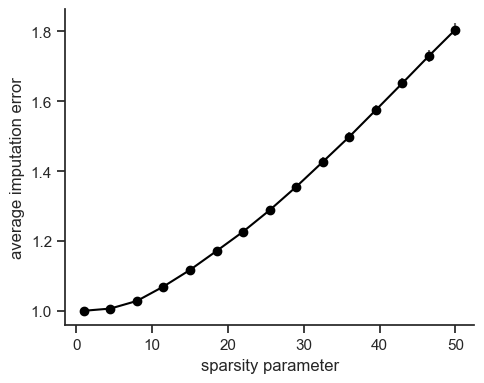

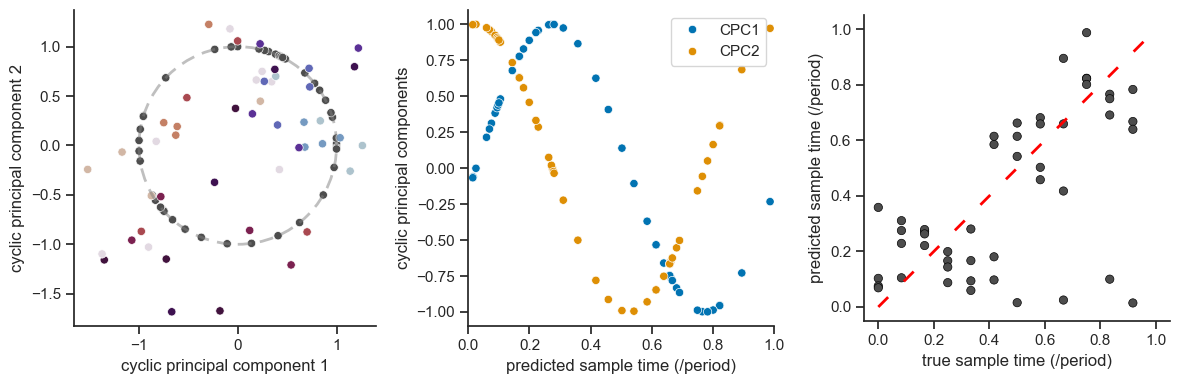

In [430]:
results_train_diet_m = COFE.analyse.predict_time(X_train_m, cv_m, true_times=true_time_train_m.to_numpy(), period=24)
COFE.plot.plot_cv_run(results_train_diet_m, figsize=(5,4))
COFE.plot.plot_circular_ordering(results_train_diet_m, time=true_time_train_m.to_numpy(), X=X_train_m, figsize=(12, 4), period=24)

In [432]:
results_train_diet_m["MAPE"]*24

np.float64(2.8750782695961767)

### COFE: BAT TRF

In [477]:
X_train_n = data_df_log[(adata.var['tissue'] == 'BAT') & (adata.var['diet'] == 'TRF')]
true_time_train_n = adata.var[(adata.var['tissue'] == 'BAT') & (adata.var['diet'] == 'TRF')]['time'].astype(int)

X_train_n, X_test_n, features_n, features_std_n = COFE.analyse.preprocess_data(X_train_n.to_numpy(), None, 
                                                                           features=X_train_n.columns, feature_dim='col',
                                                                           mean_threshold=1, scaling_threshold=2.8)
X_train_n.shape # (Samples, Transcripts)

(24, 6189)

In [523]:
s_choices = np.linspace(1, 50, 15)
cv_n = COFE.analyse.cross_validate(X_train_n, s_choices, features=features_n, K=5, ncores=-1)

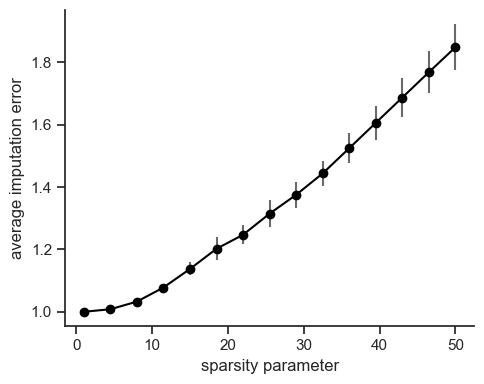

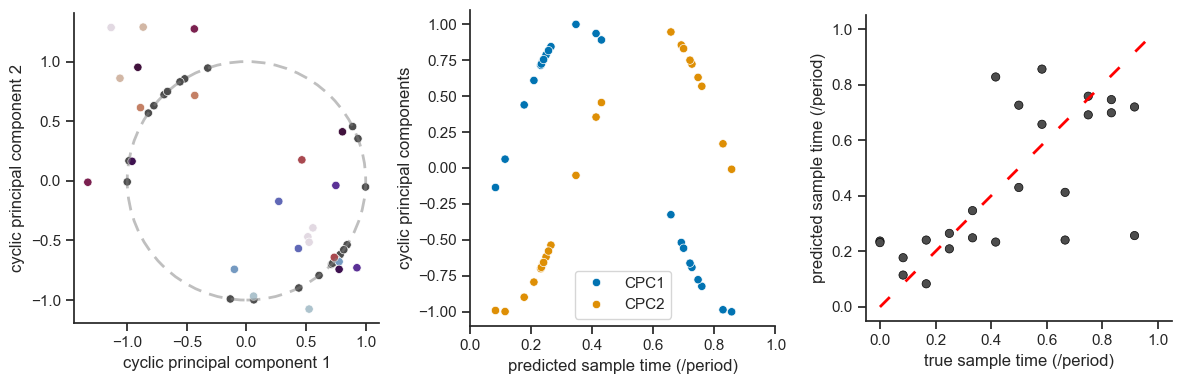

In [524]:
results_train_diet_n = COFE.analyse.predict_time(X_train_n, cv_n, true_times=true_time_train_n.to_numpy(), period=24)
COFE.plot.plot_cv_run(results_train_diet_n, figsize=(5,4))
COFE.plot.plot_circular_ordering(results_train_diet_n, time=true_time_train_n.to_numpy(), X=X_train_n, figsize=(12, 4), period=24)

In [525]:
results_train_diet_n["MAPE"]*24

np.float64(2.169205411161809)

### COFE: BAT ALF

In [768]:
X_train_p = data_df_log[(adata.var['tissue'] == 'BAT') & (adata.var['diet'] == 'ALF')]
true_time_train_p = adata.var[(adata.var['tissue'] == 'BAT') & (adata.var['diet'] == 'ALF')]['time'].astype(int)

X_train_p, X_test_p, features_p, features_std_p = COFE.analyse.preprocess_data(X_train_p.to_numpy(), None, 
                                                                           features=X_train_p.columns, feature_dim='col',
                                                                           mean_threshold=1, scaling_threshold=2.9)
X_train_p.shape # (Samples, Transcripts)

(24, 7645)

In [769]:
s_choices = np.linspace(1, 50, 15)
cv_p = COFE.analyse.cross_validate(X_train_p, s_choices, features=features_p, K=5, ncores=-1)

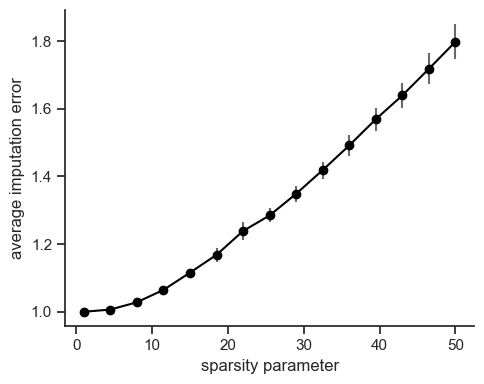

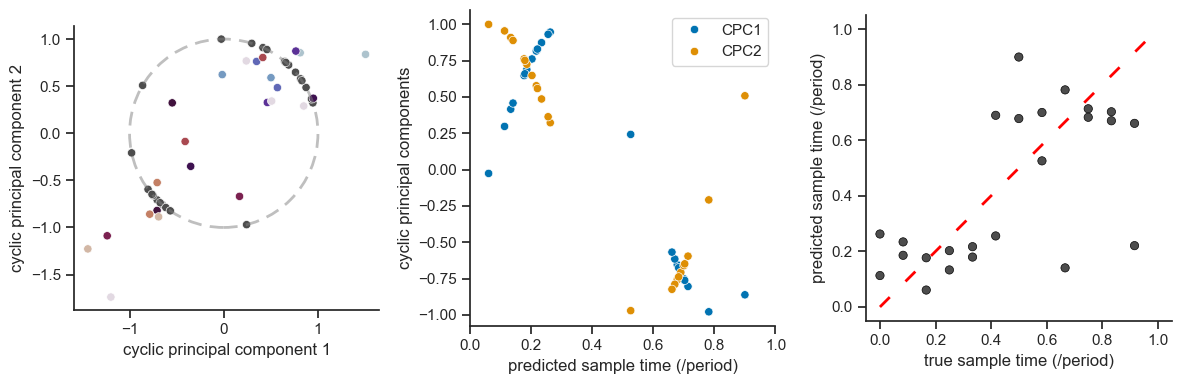

In [770]:
results_train_diet_p = COFE.analyse.predict_time(X_train_p, cv_p, true_times=true_time_train_p.to_numpy(), period=24)
COFE.plot.plot_cv_run(results_train_diet_p, figsize=(5,4))
COFE.plot.plot_circular_ordering(results_train_diet_p, time=true_time_train_p.to_numpy(), X=X_train_p, figsize=(12, 4), period=24)

In [771]:
results_train_diet_p["MAPE"]*24

np.float64(2.9685436422907774)

## COFE: Lung

### COFE: Lung All Samples

In [509]:
X_train_1 = data_df_log[(adata.var['tissue'] == 'Lung')]
true_time_train_1 = adata.var[(adata.var['tissue'] == 'Lung')]['time'].astype(int)

X_train_1, X_test_1, features_1, features_std_1 = COFE.analyse.preprocess_data(X_train_1.to_numpy(), None, 
                                                                           features=X_train_1.columns, feature_dim='col',
                                                                           mean_threshold=1, scaling_threshold=2.9)
X_train_1.shape # (Samples, Transcripts)

(46, 8163)

In [510]:
s_choices = np.linspace(1, 50, 15)
cv_1 = COFE.analyse.cross_validate(X_train_1, s_choices, features=features_1, K=5, ncores=-1)

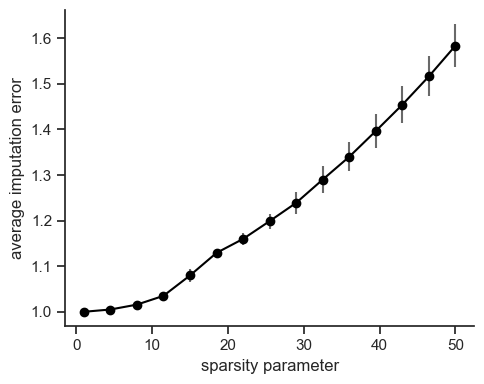

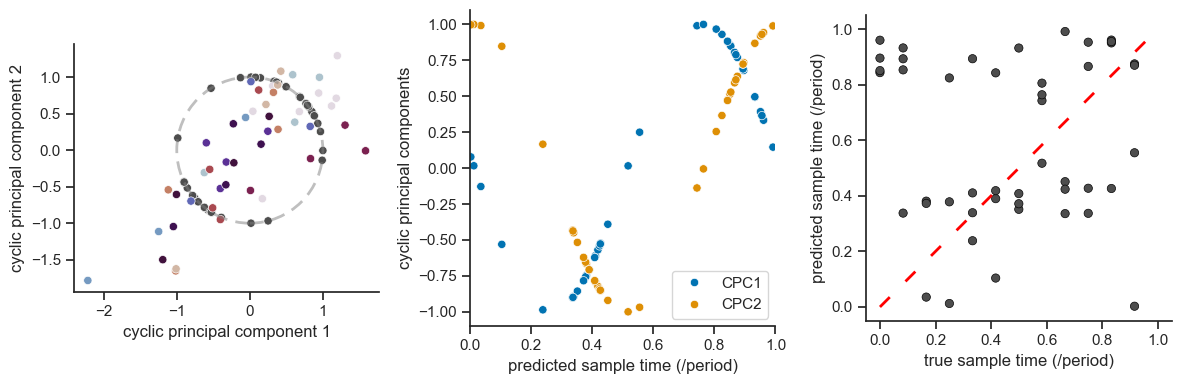

In [511]:
results_train_diet_1 = COFE.analyse.predict_time(X_train_1, cv_1, true_times=true_time_train_1.to_numpy(), period=24)
COFE.plot.plot_cv_run(results_train_diet_1, figsize=(5,4))
COFE.plot.plot_circular_ordering(results_train_diet_1, time=true_time_train_1.to_numpy(), X=X_train_1, figsize=(12, 4), period=24)

In [512]:
results_train_diet_1["MAPE"]*24

np.float64(3.789022942036874)

#### COFE: Lung TRF

In [520]:
X_train_2 = data_df_log[(adata.var['tissue'] == 'Lung')& (adata.var['diet'] == 'TRF')]
true_time_train_2 = adata.var[(adata.var['tissue'] == 'Lung')& (adata.var['diet'] == 'TRF')]['time'].astype(int)

X_train_2, X_test_2, features_2, features_std_2 = COFE.analyse.preprocess_data(X_train_2.to_numpy(), None, 
                                                                           features=X_train_2.columns, feature_dim='col',
                                                                           mean_threshold=1, scaling_threshold=2.7)
X_train_2.shape # (Samples, Transcripts)

(23, 6751)

In [517]:
s_choices = np.linspace(1, 50, 15)
cv_2 = COFE.analyse.cross_validate(X_train_2, s_choices, features=features_2, K=5, ncores=-1)

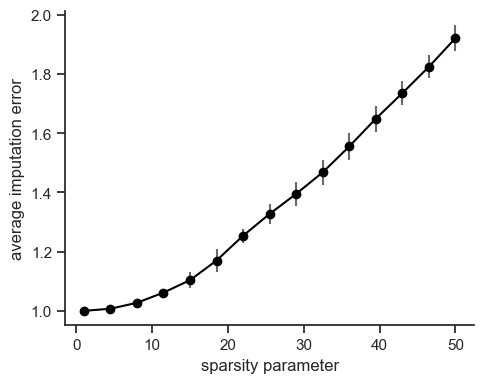

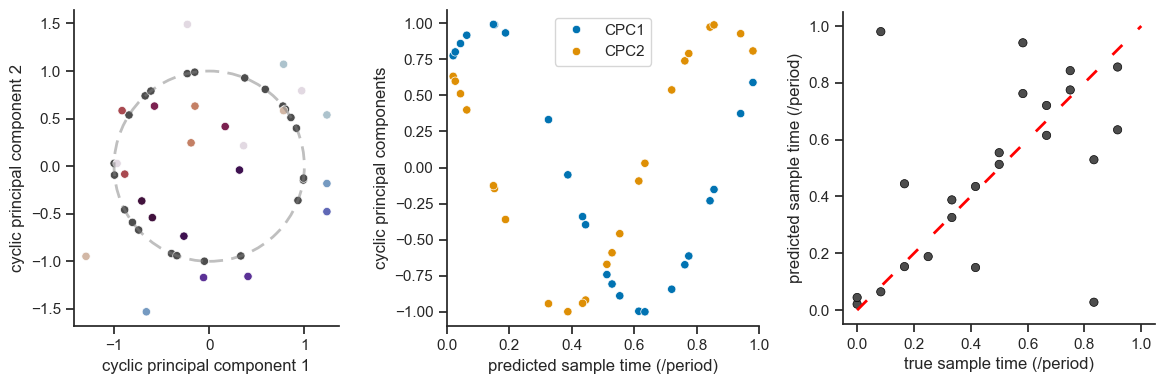

In [521]:
results_train_diet_2 = COFE.analyse.predict_time(X_train_2, cv_2, true_times=true_time_train_2.to_numpy(), period=24)
COFE.plot.plot_cv_run(results_train_diet_2, figsize=(5,4))
COFE.plot.plot_circular_ordering(results_train_diet_2, time=true_time_train_2.to_numpy(), X=X_train_2, figsize=(12, 4), period=24)

In [522]:
results_train_diet_2["MAPE"]*24

np.float64(1.3130263918478065)

#### COFE: Lung ALF

In [565]:
X_train_3 = data_df_log[(adata.var['tissue'] == 'Lung')& (adata.var['diet'] == 'ALF')]
true_time_train_3 = adata.var[(adata.var['tissue'] == 'Lung')& (adata.var['diet'] == 'ALF')]['time'].astype(int)

X_train_3, X_test_3, features_3, features_std_3 = COFE.analyse.preprocess_data(X_train_3.to_numpy(), None, 
                                                                           features=X_train_3.columns, feature_dim='col',
                                                                           mean_threshold=1, scaling_threshold=3.2)
X_train_3.shape # (Samples, Transcripts)

(23, 10221)

In [566]:
s_choices = np.linspace(1, 50, 15)
cv_3 = COFE.analyse.cross_validate(X_train_3, s_choices, features=features_3, K=5, ncores=-1)

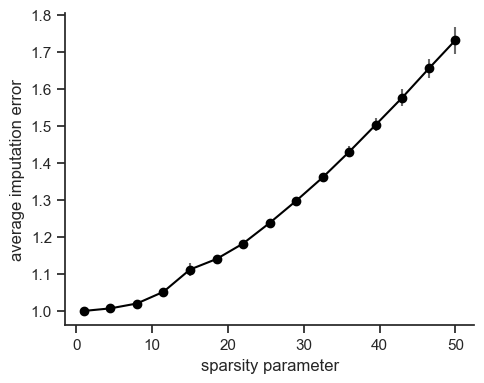

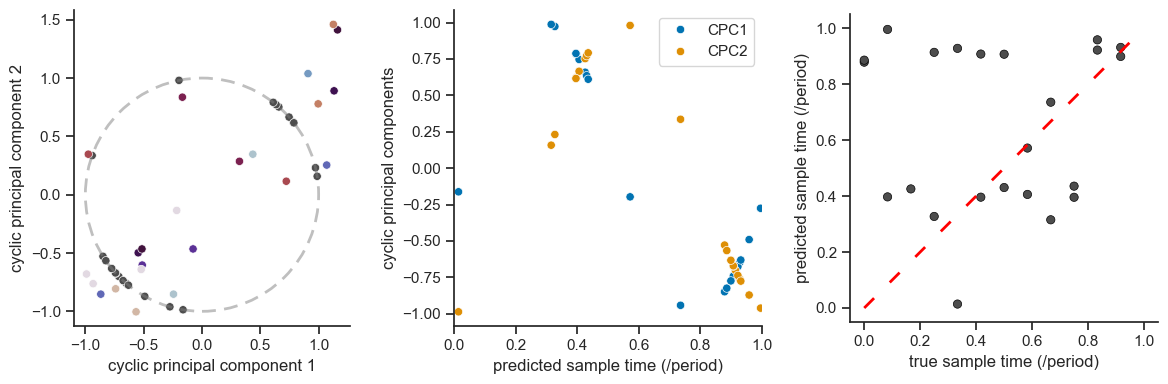

In [569]:
results_train_diet_3 = COFE.analyse.predict_time(X_train_3, cv_3, true_times=true_time_train_3.to_numpy(), period=24)
COFE.plot.plot_cv_run(results_train_diet_3, figsize=(5,4))
COFE.plot.plot_circular_ordering(results_train_diet_3, time=true_time_train_3.to_numpy(), X=X_train_3, figsize=(12, 4), period=24)

In [568]:
results_train_diet_3["MAPE"]*24

np.float64(3.000927073598681)

## COFE: Muscle

### COFE: Muscle All Samples

In [575]:
X_train_4 = data_df_log[(adata.var['tissue'] == 'Muscle')]
true_time_train_4 = adata.var[(adata.var['tissue'] == 'Muscle')]['time'].astype(int)

X_train_4, X_test_4, features_4, features_std_4 = COFE.analyse.preprocess_data(X_train_4.to_numpy(), None, 
                                                                           features=X_train_4.columns, feature_dim='col',
                                                                           mean_threshold=1, scaling_threshold=3.9)
X_train_4.shape # (Samples, Transcripts)

(48, 9256)

In [576]:
s_choices = np.linspace(1, 50, 15)
cv_4 = COFE.analyse.cross_validate(X_train_4, s_choices, features=features_4, K=5, ncores=-1)

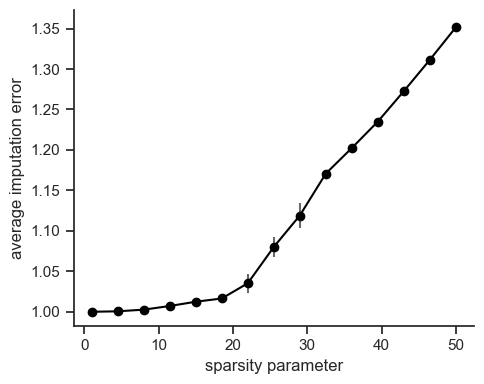

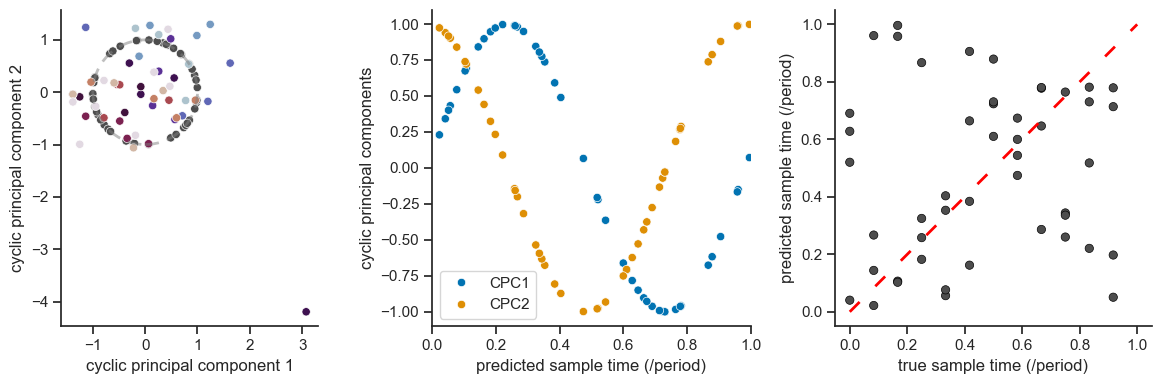

In [577]:
results_train_diet_4 = COFE.analyse.predict_time(X_train_4, cv_4, true_times=true_time_train_4.to_numpy(), period=24)
COFE.plot.plot_cv_run(results_train_diet_4, figsize=(5,4))
COFE.plot.plot_circular_ordering(results_train_diet_4, time=true_time_train_4.to_numpy(), X=X_train_4, figsize=(12, 4), period=24)

In [578]:
results_train_diet_4["MAPE"]*24

np.float64(3.2570424419386086)

### COFE: Muscle TRF

In [618]:
X_train_5 = data_df_log[(adata.var['tissue'] == 'Muscle')& (adata.var['diet'] == 'TRF')]
true_time_train_5 = adata.var[(adata.var['tissue'] == 'Muscle')&(adata.var['diet'] == 'TRF')]['time'].astype(int)

X_train_5, X_test_5, features_5, features_std_5 = COFE.analyse.preprocess_data(X_train_5.to_numpy(), None, 
                                                                           features=X_train_5.columns, feature_dim='col',
                                                                           mean_threshold=1, scaling_threshold=6.5)
X_train_5.shape # (Samples, Transcripts)

(24, 3792)

In [619]:
s_choices = np.linspace(1, 50, 15)
cv_5 = COFE.analyse.cross_validate(X_train_5, s_choices, features=features_5, K=5, ncores=-1)

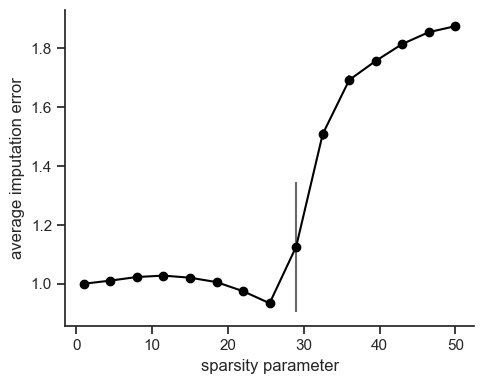

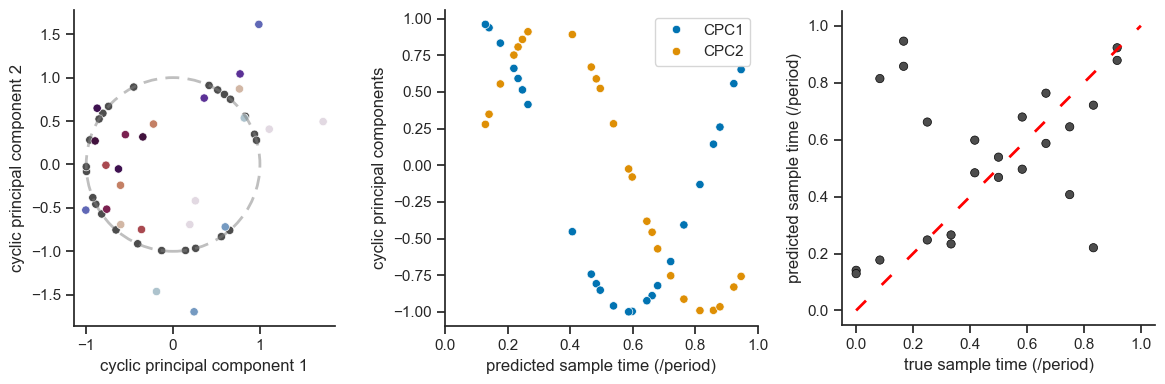

In [620]:
results_train_diet_5 = COFE.analyse.predict_time(X_train_5, cv_5, true_times=true_time_train_5.to_numpy(), period=24)
COFE.plot.plot_cv_run(results_train_diet_5, figsize=(5,4))
COFE.plot.plot_circular_ordering(results_train_diet_5, time=true_time_train_5.to_numpy(), X=X_train_5, figsize=(12, 4), period=24)

In [621]:
results_train_diet_5["MAPE"]*24

np.float64(2.3534694871411537)

### COFE: Muscle ALF

In [752]:
X_train_6 = data_df_log[(adata.var['tissue'] == 'Muscle')& (adata.var['diet'] == 'ALF')]
true_time_train_6 = adata.var[(adata.var['tissue'] == 'Muscle')&(adata.var['diet'] == 'ALF')]['time'].astype(int)

X_train_6, X_test_6, features_6, features_std_6 = COFE.analyse.preprocess_data(X_train_6.to_numpy(), None, 
                                                                           features=X_train_6.columns, feature_dim='col',
                                                                           mean_threshold=1, scaling_threshold=2.95)
X_train_6.shape # (Samples, Transcripts)

(24, 8244)

In [756]:
s_choices = np.linspace(1, 50, 15)
cv_6 = COFE.analyse.cross_validate(X_train_6, s_choices, features=features_6, K=5, ncores=-1)

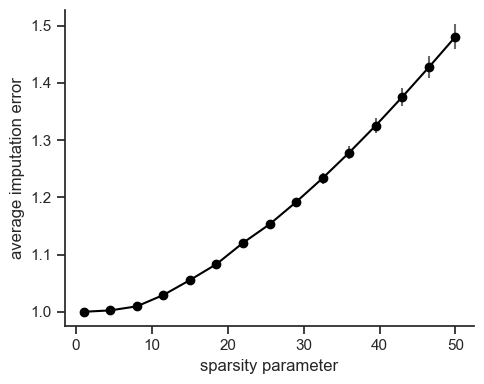

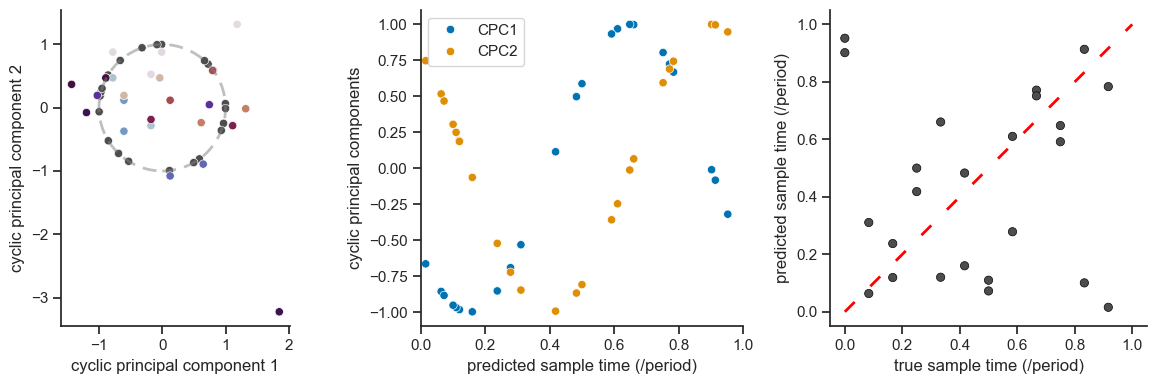

In [757]:
results_train_diet_6 = COFE.analyse.predict_time(X_train_6, cv_6, true_times=true_time_train_6.to_numpy(), period=24)
COFE.plot.plot_cv_run(results_train_diet_6, figsize=(5,4))
COFE.plot.plot_circular_ordering(results_train_diet_6, time=true_time_train_6.to_numpy(), X=X_train_6, figsize=(12, 4), period=24)

In [759]:
results_train_diet_6["MAPE"]*24

np.float64(2.8514441924433545)

## COFE: Jejunum

### COFE: Jejunum TRF

In [668]:
X_train_7 = data_df_log[(adata.var['tissue'] == 'Jejunum')& (adata.var['diet'] == 'TRF')]
true_time_train_7 = adata.var[(adata.var['tissue'] == 'Jejunum')&(adata.var['diet'] == 'TRF')]['time'].astype(int)

X_train_7, X_test_7, features_7, features_std_7 = COFE.analyse.preprocess_data(X_train_7.to_numpy(), None, 
                                                                           features=X_train_7.columns, feature_dim='col',
                                                                           mean_threshold=1, scaling_threshold=4.3)
X_train_7.shape # (Samples, Transcripts)

(24, 10524)

In [669]:
s_choices = np.linspace(1, 50, 15)
cv_7 = COFE.analyse.cross_validate(X_train_7, s_choices, features=features_7, K=5, ncores=-1)

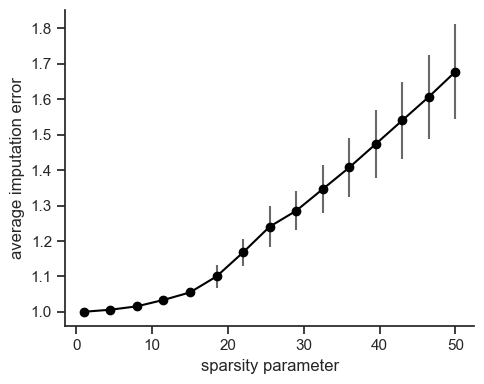

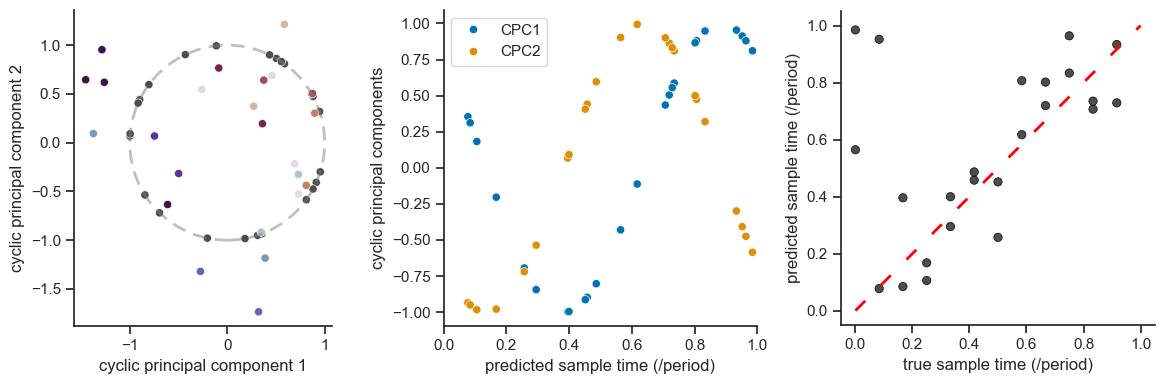

In [670]:
results_train_diet_7 = COFE.analyse.predict_time(X_train_7, cv_7, true_times=true_time_train_7.to_numpy(), period=24)
COFE.plot.plot_cv_run(results_train_diet_7, figsize=(5,4))
COFE.plot.plot_circular_ordering(results_train_diet_7, time=true_time_train_7.to_numpy(), X=X_train_7, figsize=(12, 4), period=24)

In [671]:
results_train_diet_7["MAPE"]*24

np.float64(1.9877019937182574)

### COFE: Jejunum ALF

In [691]:
X_train_8 = data_df_log[(adata.var['tissue'] == 'Jejunum')& (adata.var['diet'] == 'ALF')]
true_time_train_8 = adata.var[(adata.var['tissue'] == 'Jejunum')&(adata.var['diet'] == 'ALF')]['time'].astype(int)

X_train_8, X_test_8, features_8, features_std_8 = COFE.analyse.preprocess_data(X_train_8.to_numpy(), None, 
                                                                           features=X_train_8.columns, feature_dim='col',
                                                                           mean_threshold=1, scaling_threshold=4.5)
X_train_8.shape # (Samples, Transcripts)

(24, 5266)

In [692]:
s_choices = np.linspace(1, 50, 15)
cv_8 = COFE.analyse.cross_validate(X_train_8, s_choices, features=features_8, K=5, ncores=-1)

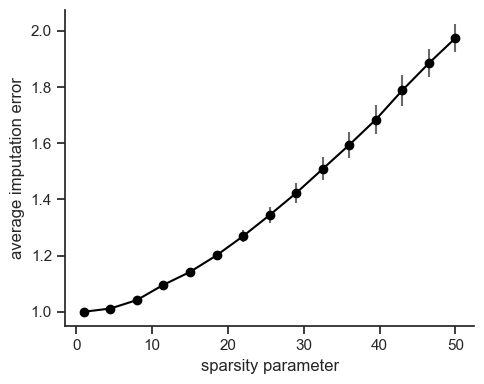

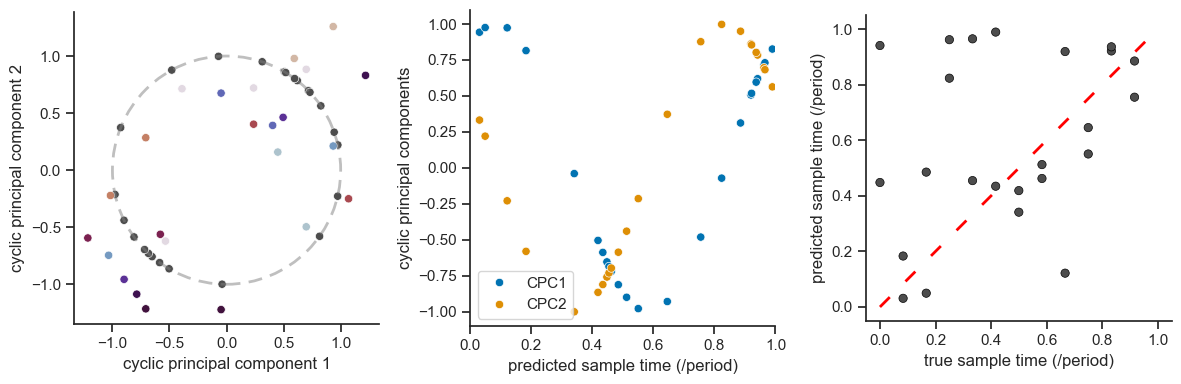

In [693]:
results_train_diet_8 = COFE.analyse.predict_time(X_train_8, cv_8, true_times=true_time_train_8.to_numpy(), period=24)
COFE.plot.plot_cv_run(results_train_diet_8, figsize=(5,4))
COFE.plot.plot_circular_ordering(results_train_diet_8, time=true_time_train_8.to_numpy(), X=X_train_8, figsize=(12, 4), period=24)

In [694]:
results_train_diet_8["MAPE"]*24

np.float64(2.908678633539102)

## COFE: Liver 

### COFE: Liver TRF

In [760]:
X_train_9 = data_df_log[(adata.var['tissue'] == 'Liver')& (adata.var['diet'] == 'TRF')]
true_time_train_9 = adata.var[(adata.var['tissue'] == 'Liver')&(adata.var['diet'] == 'TRF')]['time'].astype(int)

X_train_9, X_test_9, features_9, features_std_9 = COFE.analyse.preprocess_data(X_train_9.to_numpy(), None, 
                                                                           features=X_train_9.columns, feature_dim='col',
                                                                           mean_threshold=1, scaling_threshold=4)
X_train_9.shape # (Samples, Transcripts)

(24, 5965)

In [761]:
s_choices = np.linspace(1, 50, 15)
cv_9 = COFE.analyse.cross_validate(X_train_9, s_choices, features=features_9, K=5, ncores=-1)

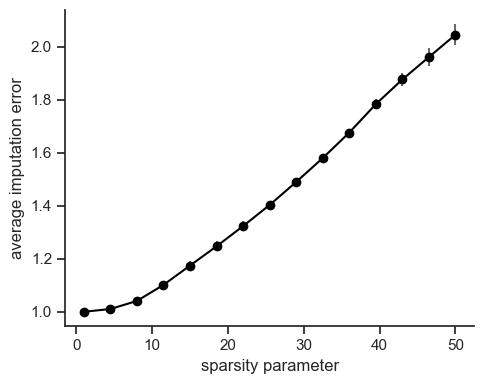

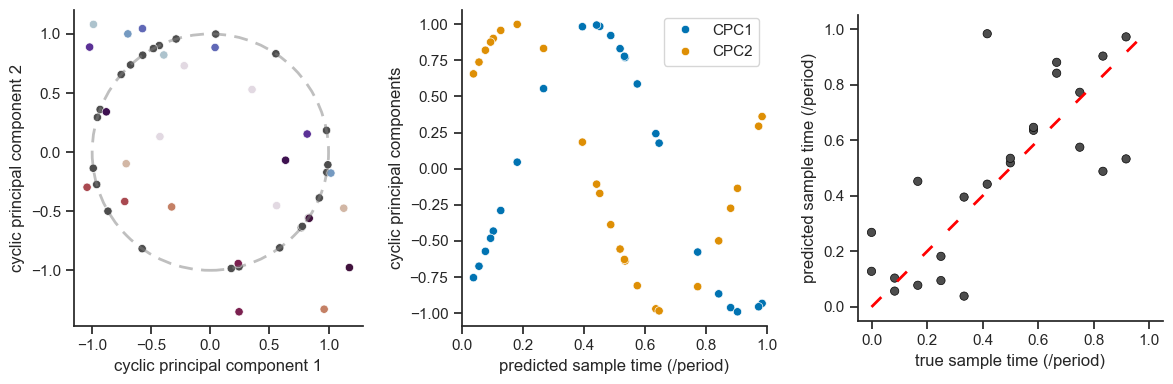

In [762]:
results_train_diet_9 = COFE.analyse.predict_time(X_train_9, cv_9, true_times=true_time_train_9.to_numpy(), period=24)
COFE.plot.plot_cv_run(results_train_diet_9, figsize=(5,4))
COFE.plot.plot_circular_ordering(results_train_diet_9, time=true_time_train_9.to_numpy(), X=X_train_9, figsize=(12, 4), period=24)

In [763]:
results_train_diet_9["MAPE"]*24

np.float64(1.902895111534841)

### COFE: Liver ALF

In [713]:
X_train_10 = data_df_log[(adata.var['tissue'] == 'Liver')& (adata.var['diet'] == 'ALF')]
true_time_train_10 = adata.var[(adata.var['tissue'] == 'Liver')&(adata.var['diet'] == 'ALF')]['time'].astype(int)

X_train_10, X_test_10, features_10, features_std_10 = COFE.analyse.preprocess_data(X_train_10.to_numpy(), None, 
                                                                           features=X_train_10.columns, feature_dim='col',
                                                                           mean_threshold=1, scaling_threshold=3.7)
X_train_10.shape # (Samples, Transcripts)

(24, 7542)

In [714]:
s_choices = np.linspace(1, 50, 15)
cv_10 = COFE.analyse.cross_validate(X_train_10, s_choices, features=features_10, K=5, ncores=-1)

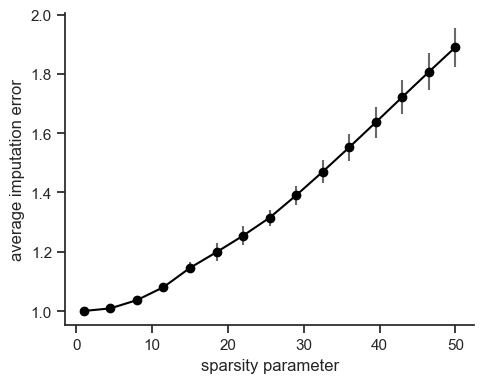

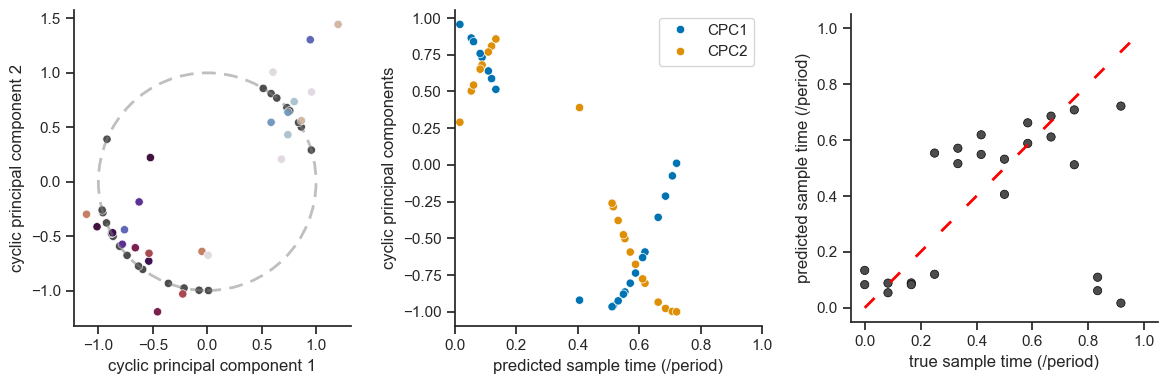

In [715]:
results_train_diet_10 = COFE.analyse.predict_time(X_train_10, cv_10, true_times=true_time_train_10.to_numpy(), period=24)
COFE.plot.plot_cv_run(results_train_diet_10, figsize=(5,4))
COFE.plot.plot_circular_ordering(results_train_diet_10, time=true_time_train_10.to_numpy(), X=X_train_10, figsize=(12, 4), period=24)

In [716]:
results_train_diet_10["MAPE"]*24

np.float64(2.3294227134447283)

## COFE: Heart

### COFE: Heart TRF

In [726]:
X_train_11 = data_df_log[(adata.var['tissue'] == 'Heart')& (adata.var['diet'] == 'TRF')]
true_time_train_11 = adata.var[(adata.var['tissue'] == 'Heart')&(adata.var['diet'] == 'TRF')]['time'].astype(int)

X_train_11, X_test_11, features_11, features_std_11 = COFE.analyse.preprocess_data(X_train_11.to_numpy(), None, 
                                                                           features=X_train_11.columns, feature_dim='col',
                                                                           mean_threshold=1, scaling_threshold=5.7)
X_train_11.shape # (Samples, Transcripts)

(24, 7731)

In [727]:
s_choices = np.linspace(1, 50, 15)
cv_11 = COFE.analyse.cross_validate(X_train_11, s_choices, features=features_11, K=5, ncores=-1)

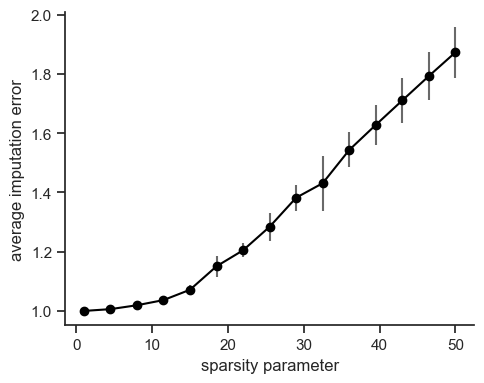

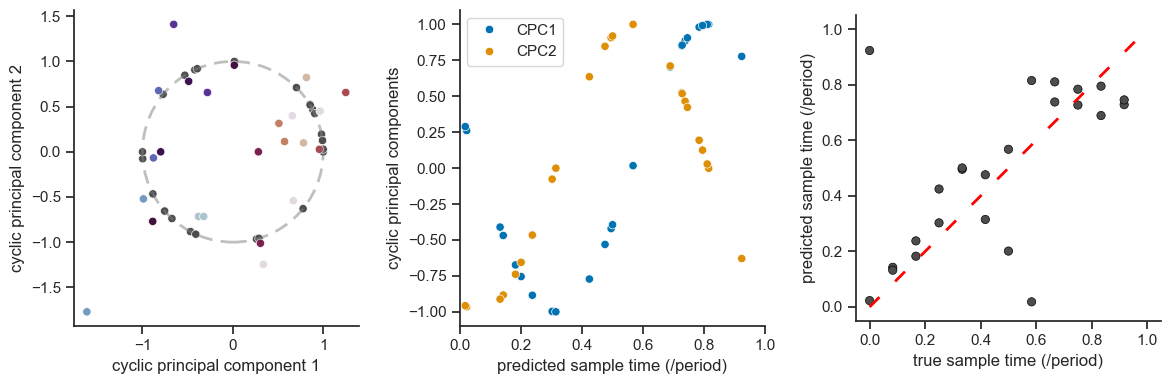

In [728]:
results_train_diet_11 = COFE.analyse.predict_time(X_train_11, cv_11, true_times=true_time_train_11.to_numpy(), period=24)
COFE.plot.plot_cv_run(results_train_diet_11, figsize=(5,4))
COFE.plot.plot_circular_ordering(results_train_diet_11, time=true_time_train_11.to_numpy(), X=X_train_11, figsize=(12, 4), period=24)

In [729]:
results_train_diet_11["MAPE"]*24

np.float64(1.776158278234691)

### COFE: Heart ALF

In [734]:
X_train_12 = data_df_log[(adata.var['tissue'] == 'Heart')& (adata.var['diet'] == 'ALF')]
true_time_train_12 = adata.var[(adata.var['tissue'] == 'Heart')&(adata.var['diet'] == 'ALF')]['time'].astype(int)

X_train_12, X_test_12, features_12, features_std_12 = COFE.analyse.preprocess_data(X_train_12.to_numpy(), None, 
                                                                           features=X_train_12.columns, feature_dim='col',
                                                                           mean_threshold=1, scaling_threshold=7.7)
X_train_12.shape # (Samples, Transcripts)

(24, 7859)

In [735]:
s_choices = np.linspace(1, 50, 15)
cv_12 = COFE.analyse.cross_validate(X_train_12, s_choices, features=features_12, K=5, ncores=-1)

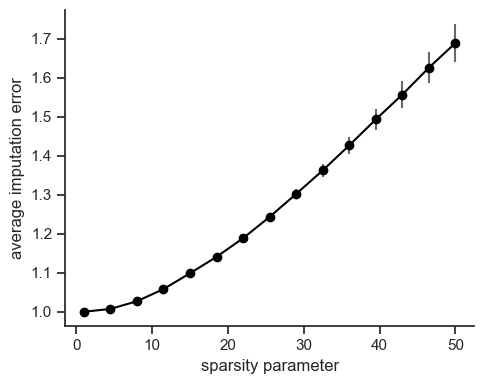

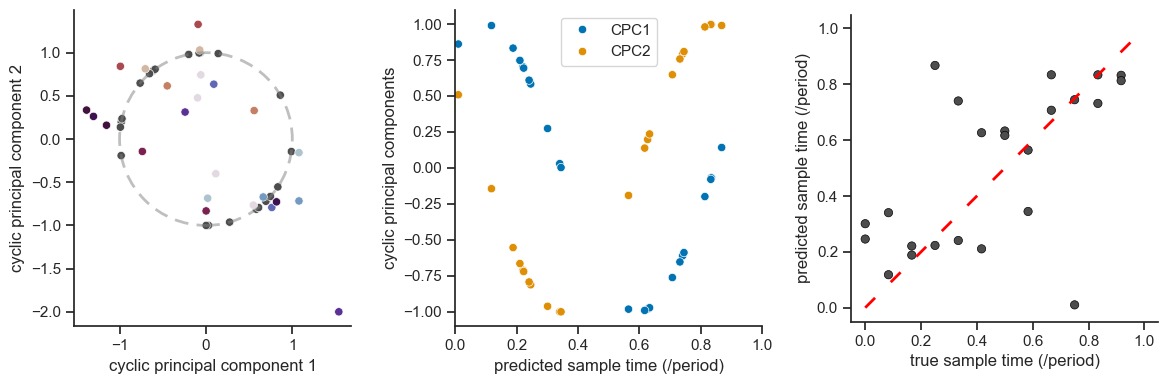

In [736]:
results_train_diet_12 = COFE.analyse.predict_time(X_train_12, cv_12, true_times=true_time_train_12.to_numpy(), period=24)
COFE.plot.plot_cv_run(results_train_diet_12, figsize=(5,4))
COFE.plot.plot_circular_ordering(results_train_diet_12, time=true_time_train_12.to_numpy(), X=X_train_12, figsize=(12, 4), period=24)

In [738]:
results_train_diet_12["MAPE"]*24

np.float64(2.646992540472562)

# Conclusion

So, I only applied COFE to a subset of the tissues/organs, but investigated how COFE predicts time for all samples together and separately for timed restricted and ad libitum feeding groups. As expected, COFE gives a poor prediction when all samples, TRF and ALF togehter, of a given organ are used. The main reason for this is that TRF upregulates a large number of genes and the results are likely to conflict when fewer rhythmic, downregulated genes of ALF are also present in the dataset. However, looking at TRF and ALF samples from each organ in isolation gives an interesting insight into how COFE performs in certain tissue types and how influential factors such as your dietary behavior can be. Below is a brief summary of the MAPE results for specific organs and the number of rhythmic genes identified in these organs (from the paper mentioned in the description).

- Adrenal TRF ->    MAPE: 2.1 -> 2008 genes; ALF ->     MAPE: 4.08 -> 941 genes
- Amygdala TRF ->   MAPE: 2.88 -> 427 genes; ALF ->     MAPE: 3.07 -> 19 genes
- Arcuate TRF ->    MAPE: 2.82 -> 195 genes; ALF ->     MAPE: 3.03 -> 36 genes
- BAT TRF ->        MAPE: 2.16 -> 2996 genes; ALF ->    MAPE: 2.96 -> 617 genes
- Lung TRF ->       MAPE: 1.31 -> 3526 genes; ALF ->    MAPE: 3.00 -> 1617 genes
- Muscle TRF ->     MAPE: 2.35 -> 2162 genes; ALF ->    MAPE: 2.96 -> 902 genes
- Jejunum TRF ->    MAPE: 1.98 -> 4838 genes; ALF ->    MAPE: 2.90 -> 833 genes
- Liver TRF ->      MAPE: 1.90 -> 4174 genes; ALF ->    MAPE: 2.32 -> 1317 genes
- Heart TRF ->      MAPE: 1.77 -> 4218 genes; ALF ->    MAPE: 2.64 -> 2046 genes

Does COFE perform better on TRF samples? It looks that way, but there is a big BUT: The local minimum problem of cross-validation. The found parameters can predict the time series surprisingly well in some cases, while in another, second or third run the MAPE results are very disappointing. Looking at the plot of average imputation error by sparsity parameter it grows to the infinity in many cases, which probably suggest that the prediction will probably be random (if I understand it correctly). Perhaps this is due to the small size of the data set and the fact that 24 samples are not sufficient to make a meaningful prediction. If so, these samples perform quite well even compared to the larger mouse liver data set I analyzed previously.

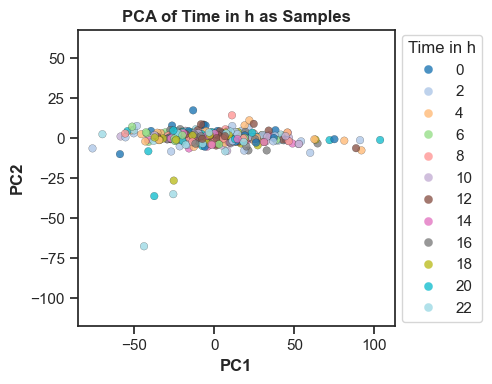

In [779]:
residual_0 = pc.residual_dummy(data=data_df_log.T[data_df_log.mean() > 1].T, data_dummy_1=adata.var['tissue'], columns='tissue')
residual_time = residual_0[adata.var['diet'] == 'TRF'].join(adata.var['time']).reset_index().set_index('time').drop('index', axis=1)
pc.principal_component_2d_timesample(data=residual_time, x=1, y=2, label='Time in h', c_map='tab20')

/Users/maksimsgolubovics/Python_VScode/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


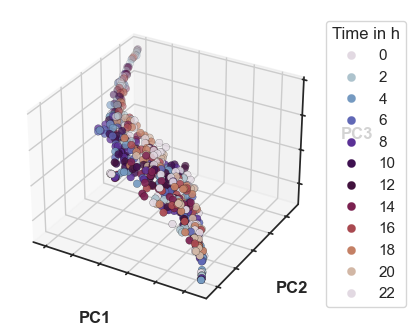

In [789]:

pc.visualization_of_dec_tools_3d(dec=UMAP(n_components=3), data=residual_time, label='Time in h', c_map='twilight')
plt.show()

In [803]:
X_train_13 = residual_0[adata.var['diet'] == 'TRF']
true_time_train_13 = adata.var[(adata.var['diet'] == 'TRF')]['time'].astype(int)

X_train_13, X_test_13, features_13, features_std_13 = COFE.analyse.preprocess_data(X_train_13.to_numpy(), None, 
                                                                           features=X_train_13.columns, feature_dim='col',
                                                                           mean_threshold=-1, scaling_threshold=4)
X_train_13.shape # (Samples, Transcripts)

(518, 5968)

In [797]:
s_choices = np.linspace(1, 50, 15)
cv_13 = COFE.analyse.cross_validate(X_train_13, s_choices, features=features_13, K=5, ncores=-1)

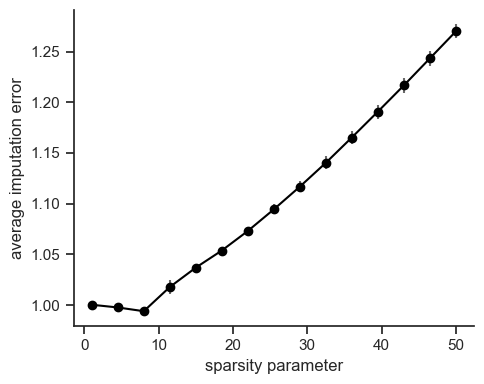

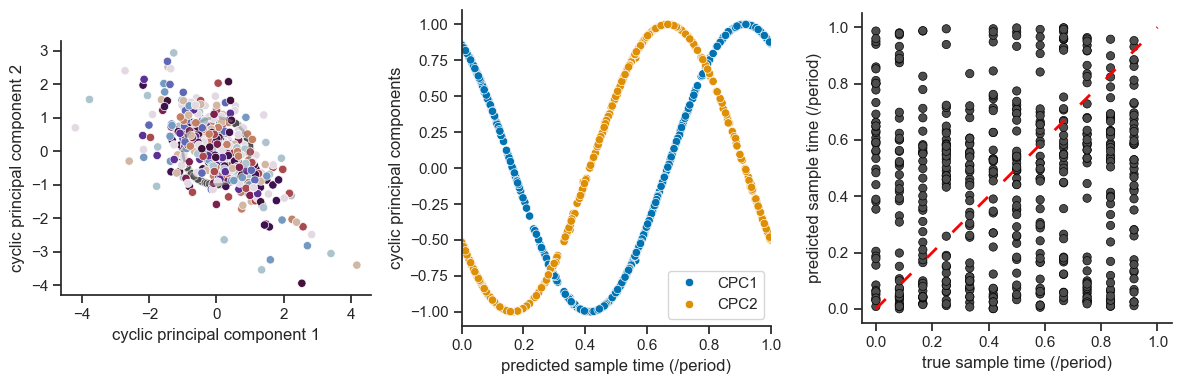

In [804]:
results_train_diet_13 = COFE.analyse.predict_time(X_train_13, cv_13, true_times=true_time_train_13.to_numpy(), period=24)
COFE.plot.plot_cv_run(results_train_diet_13, figsize=(5,4))
COFE.plot.plot_circular_ordering(results_train_diet_13, time=true_time_train_13.to_numpy(), X=X_train_13, figsize=(12, 4), period=24)